In [1]:
!pip install pyexasol
!pip install websocket-client ujson
!pip install pyodbc

In [1]:
import pyexasol
import pandas as pd

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

# Connection parameters - change the fingerprint each time you start the database

host = '192.168.56.101/E176DDD5013BFA9B9FAF6E470EF099181698FC0ED1817158CE84911F02345B5E:8563'  # Replace with your Exasol host (e.g., '192.168.0.100:8563')
user = 'sys'     # Replace with your Exasol username
password = 'exasol' # Replace with your Exasol password

# Connect to Exasol
conn = pyexasol.connect(dsn=host, user=user, password=password, debug=False, protocol_version=pyexasol.PROTOCOL_V1)






# At what times of the day/week are people using youtube?

#### Obtain Table

In [2]:
q = '''
SELECT QUERYDIM.QUERY, TIMEDIM.[month], TIMEDIM.[day of the month], (TIMEDIM.[day of the year] - 60) as DaysAfterDBStart, TIMEDIM.[hour], TIMEDIM.[minute], FACTS.QUERYID, FACTS.TIMEID, FACTS.ANONID, (TIMEDIM.[hour]*60 + TIMEDIM.[minute]) as MinutesAfterMidnight
FROM AOL_SCHEMA.QUERYDIM 
    LEFT JOIN AOL_SCHEMA.FACTS ON QUERYDIM.ID = FACTS.QUERYID
    LEFT JOIN AOL_SCHEMA.TIMEDIM ON QUERYDIM.ID = TIMEDIM.ID
    LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
WHERE FACTS.CLICK = 1 AND URLDIM.URL = 'http://www.youtube.com'
    AND (QUERYDIM.QUERY IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
        AND QUERYDIM.QUERY NOT LIKE '%youtube%'
        AND QUERYDIM.QUERY NOT LIKE '%you tube%'
        AND QUERYDIM.QUERY NOT LIKE '%your tube%')
'''
# Select (see select clause) when the youtube link was clicked

df = printQuery(q, conn)
print(df.shape, df.columns, sep="\n")




                            QUERY      month  day of the month  \
0                     jake peyton  march                     1   
1             bush drinking video  april                    26   
2  cant stop scratching my vagina  april                    26   
3                      vid idiots  april                    19   
4                 naruto websites  may                       9   

   DAYSAFTERDBSTART  hour  minute  QUERYID   TIMEID  ANONID  \
0                 0     0      13  2775687  5962961  154767   
1                56     9      31  2778308  5986392   53322   
2                56     2      19  2774391  4104872  317691   
3                49    16       6  2785441  2778338  126651   
4                69    15      44  2787473  5086065    7725   

   MINUTESAFTERMIDNIGHT  
0                    13  
1                   571  
2                   139  
3                   966  
4                   944  
(2028, 10)
Index(['QUERY', 'month', 'day of the month', 'DAYSAFTERDB

#### Combined hourly frequency of clicks

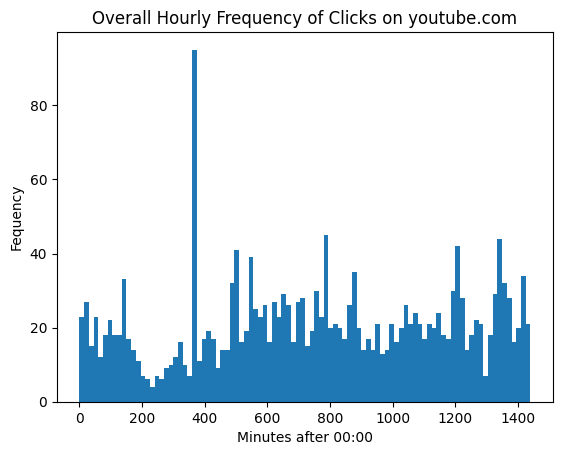

In [3]:
import matplotlib.pyplot as plt

# Overall Hourly Frequency
plt.hist(df['MINUTESAFTERMIDNIGHT'], bins=96)  # Each bin represents a 15 minute period
plt.xlabel("Minutes after 00:00")
plt.ylabel("Fequency")
plt.title("Overall Hourly Frequency of Clicks on youtube.com")
plt.show()


#### Frequency of clicks by day

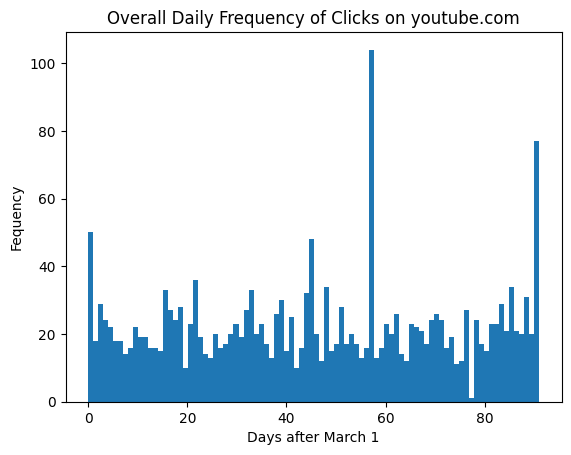

(57, 10)


7                                            rampage jackson
60                                               www.pistols
101                              welcome to silent hill .com
192                                            i pinch honda
269                                                 my space
273                                                 my space
274                                                 my space
275                                                 my space
276                                                 my space
277                                                 my space
278                                                 my space
279                                                 my space
280                                                 my space
281                                                 my space
282                                                 my space
283                                                 my space
284                     

In [4]:
# Overall Frequency Days of the Year

plt.hist(df['DAYSAFTERDBSTART'], bins=90)  # Each bin represents a day
plt.xlabel("Days after March 1")
plt.ylabel("Fequency")
plt.title("Overall Daily Frequency of Clicks on youtube.com")
plt.show()

print(df[df['DAYSAFTERDBSTART'] == 90].shape)
df[df['DAYSAFTERDBSTART'] == 90]['QUERY']

# How can queries be segmented?

#### Tokenization and embeddings of search querytext

Source: https://sbert.net/examples/applications/computing-embeddings/README.html

In [5]:
# Format input to encoder
print(df.columns)
print(df.shape)
print(df['QUERY'].values.tolist())

listOfQueries = df['QUERY'].values.tolist()

Index(['QUERY', 'month', 'day of the month', 'DAYSAFTERDBSTART', 'hour',
       'minute', 'QUERYID', 'TIMEID', 'ANONID', 'MINUTESAFTERMIDNIGHT'],
      dtype='object')
(2028, 10)
['jake peyton', 'bush drinking video', 'cant stop scratching my vagina', 'vid idiots', 'naruto websites', 'eruption-van halen', 'lip tattoos', 'rampage jackson', 'sex bomb skate program', 'beyonce skirt oop on stage', 'beyonce skirt oop on stage', 'elkins high school', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish', 'cigar smoking fetish',

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(listOfQueries , batch_size=32)


/home/chandler/anaconda3/envs/PDSP/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [7]:
# Look at embeddings

print(embeddings.shape)

(2028, 384)


#### K-Means clustering
- elbowplot
- proper K run
- assign labels
- interpretation & conclusion (may need to add more cols from DB)

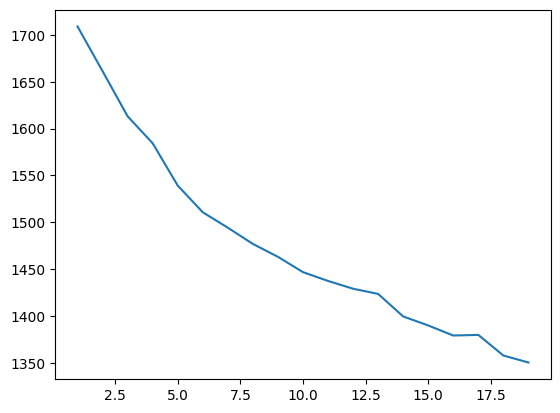

In [12]:
# Sklearn setup
from sklearn.cluster import KMeans

# Elbow plot
distortion = []
clusters = range(1,20)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(embeddings)
    distortion.append(kmeans.inertia_)

plt.plot(clusters, distortion)  # 8 appears to be a good 'elbow'


In [13]:
# Proper K run
number_of_clusters = 13
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42, n_init='auto').fit(embeddings)


In [14]:
# Assign Labels -- DF column
print(kmeans.labels_)
print(kmeans.labels_.shape)
df['ClusterLabels'] = kmeans.labels_

[ 2 10  8 ...  3  3 12]
(2028,)


#### Check the distribution of the labels
This tells us the "n" in the following histograms

Text(0, 0.5, 'Frequency')

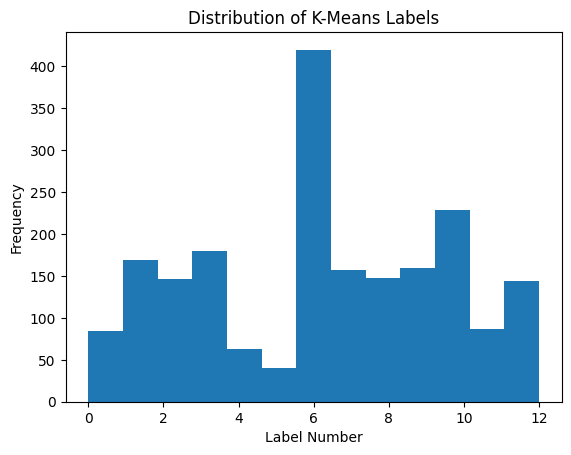

In [15]:
plt.hist(kmeans.labels_, bins=number_of_clusters)
plt.title("Distribution of K-Means Labels")
plt.xlabel("Label Number")
plt.ylabel("Frequency")

#### Plot an access time histogram for each cluster

Examine the differences in click time distributions per cluster

Cluster 0 -- Descriptive statistics and histogram
count            84
unique            3
top       may      
freq             30
Name: month, dtype: object


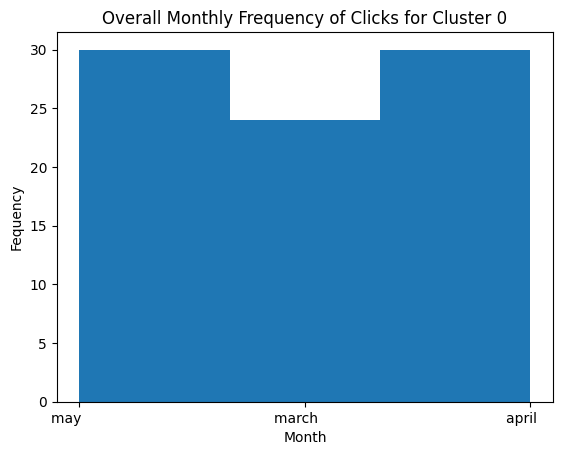

Cluster 1 -- Descriptive statistics and histogram
count           169
unique            3
top       may      
freq             64
Name: month, dtype: object


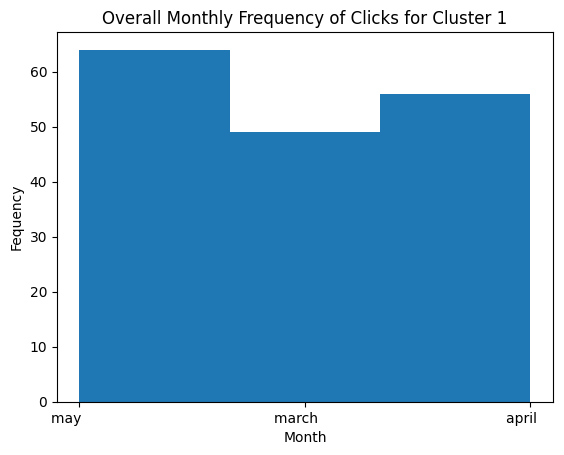

Cluster 2 -- Descriptive statistics and histogram
count           147
unique            3
top       april    
freq             62
Name: month, dtype: object


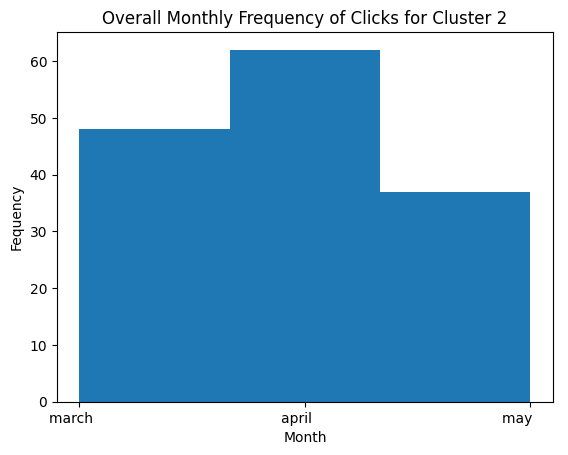

Cluster 3 -- Descriptive statistics and histogram
count           180
unique            3
top       may      
freq             63
Name: month, dtype: object


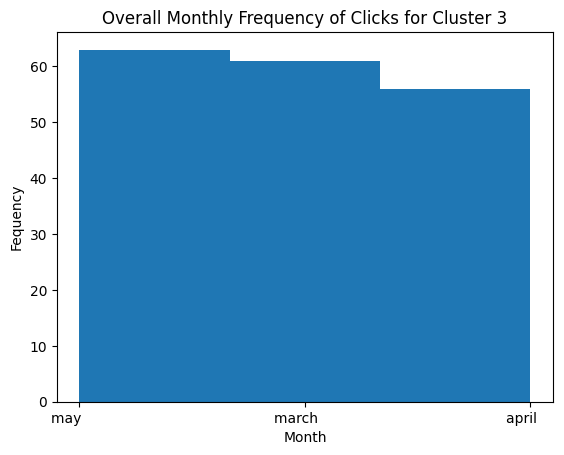

Cluster 4 -- Descriptive statistics and histogram
count            63
unique            3
top       march    
freq             32
Name: month, dtype: object


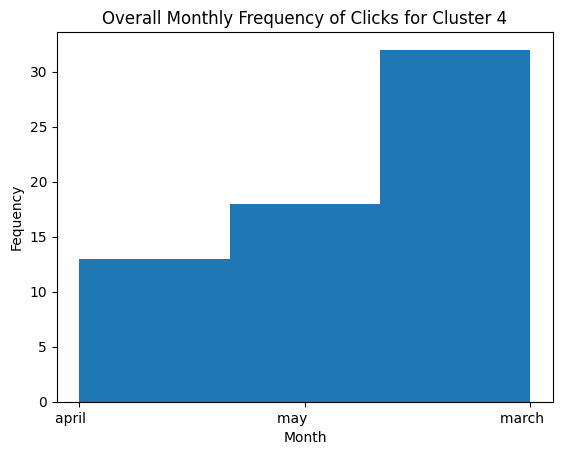

Cluster 5 -- Descriptive statistics and histogram
count            40
unique            3
top       may      
freq             25
Name: month, dtype: object


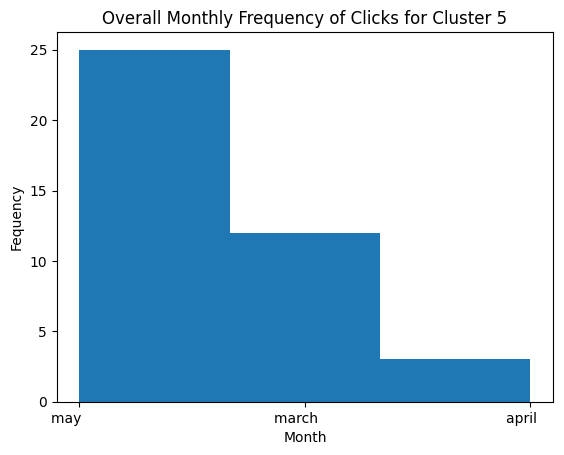

Cluster 6 -- Descriptive statistics and histogram
count           420
unique            3
top       april    
freq            184
Name: month, dtype: object


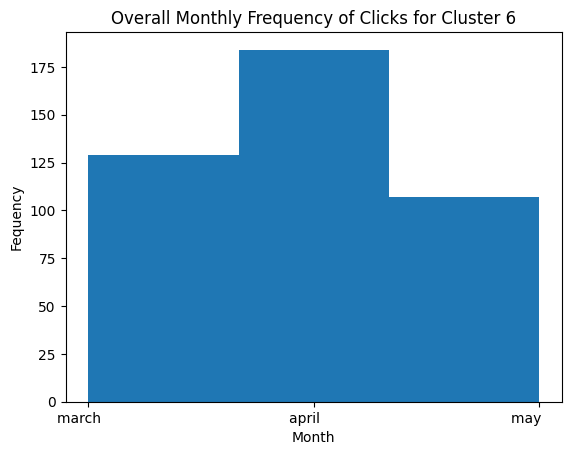

Cluster 7 -- Descriptive statistics and histogram
count           157
unique            3
top       may      
freq             66
Name: month, dtype: object


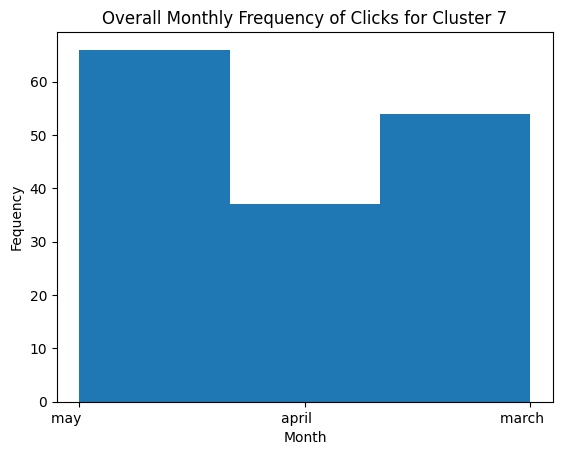

Cluster 8 -- Descriptive statistics and histogram
count           148
unique            3
top       may      
freq             55
Name: month, dtype: object


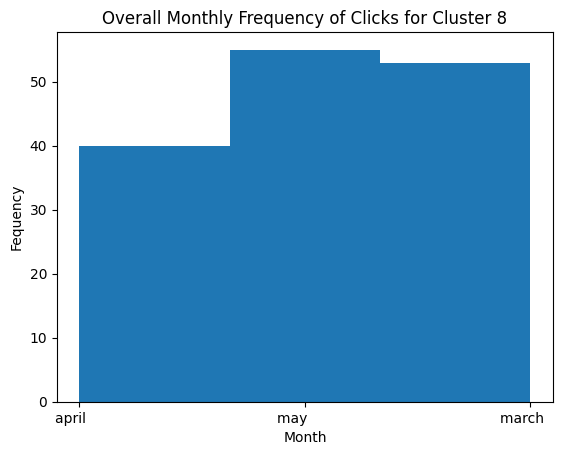

Cluster 9 -- Descriptive statistics and histogram
count           160
unique            3
top       may      
freq             56
Name: month, dtype: object


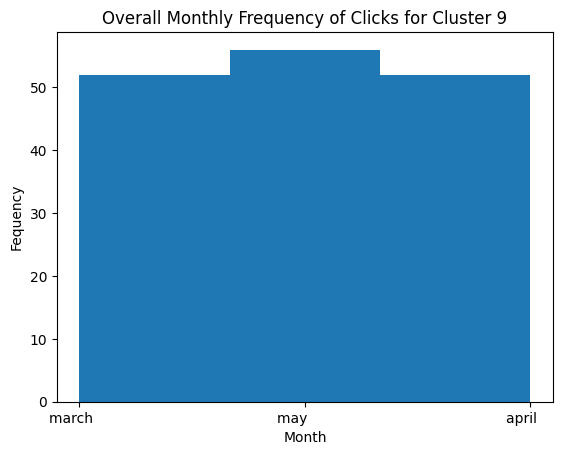

Cluster 10 -- Descriptive statistics and histogram
count           229
unique            3
top       may      
freq             92
Name: month, dtype: object


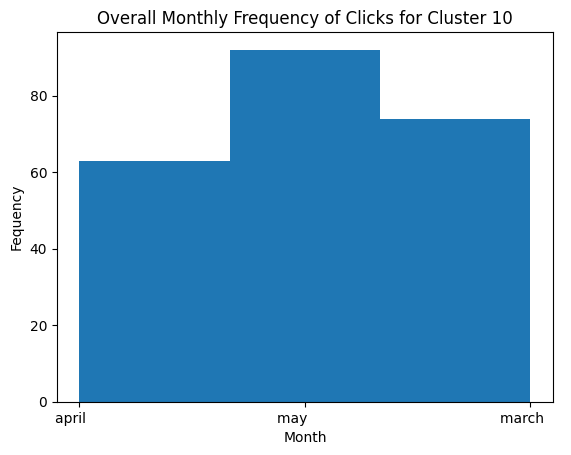

Cluster 11 -- Descriptive statistics and histogram
count            87
unique            1
top       april    
freq             87
Name: month, dtype: object


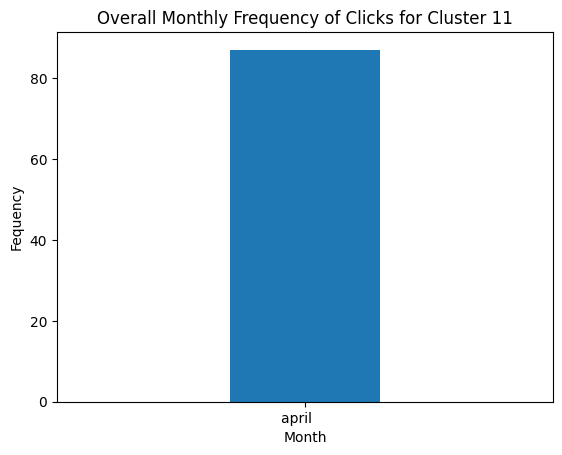

Cluster 12 -- Descriptive statistics and histogram
count           144
unique            3
top       may      
freq             57
Name: month, dtype: object


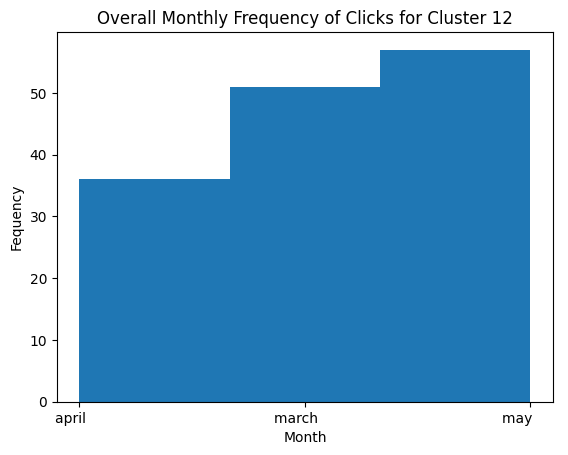

In [16]:
# At month Scale

for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['month'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['month'], bins=3)  # Each bin represents a day
    plt.xlabel("Month")
    plt.ylabel("Fequency")
    plt.title(f"Overall Monthly Frequency of Clicks for Cluster {i}")
    plt.show()

Cluster 0 -- Descriptive statistics and histogram
count    84.000000
mean     46.857143
std      25.637013
min       0.000000
25%      25.000000
50%      47.000000
75%      73.000000
max      91.000000
Name: DAYSAFTERDBSTART, dtype: float64


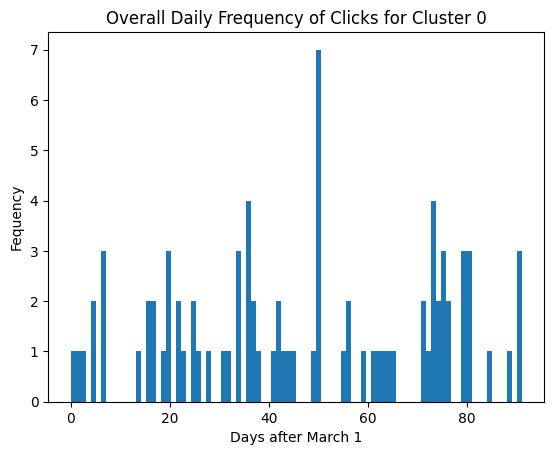

Cluster 1 -- Descriptive statistics and histogram
count    169.000000
mean      50.171598
std       26.775747
min        2.000000
25%       22.000000
50%       49.000000
75%       73.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


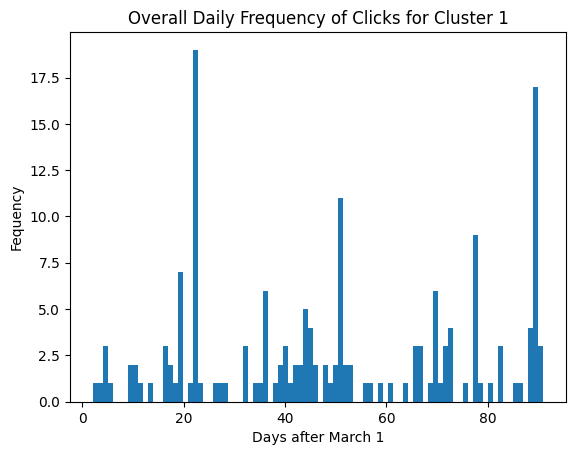

Cluster 2 -- Descriptive statistics and histogram
count    147.000000
mean      45.013605
std       26.374798
min        0.000000
25%       21.000000
50%       48.000000
75%       60.500000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


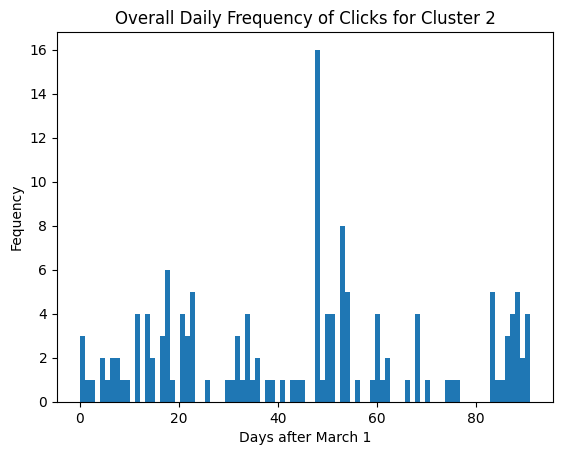

Cluster 3 -- Descriptive statistics and histogram
count    180.000000
mean      45.450000
std       27.281744
min        1.000000
25%       21.000000
50%       41.500000
75%       70.250000
max       89.000000
Name: DAYSAFTERDBSTART, dtype: float64


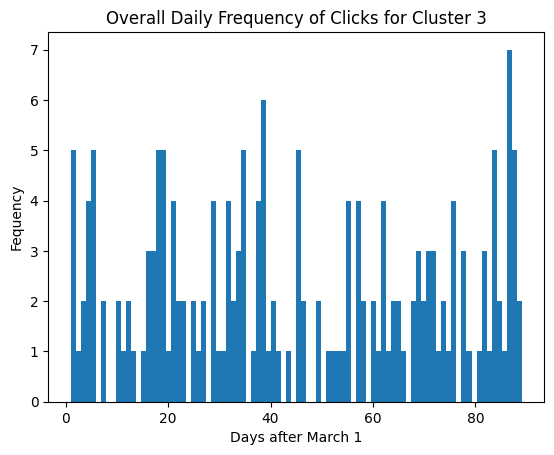

Cluster 4 -- Descriptive statistics and histogram
count    63.000000
mean     38.539683
std      29.577577
min       0.000000
25%      10.000000
50%      30.000000
75%      66.000000
max      90.000000
Name: DAYSAFTERDBSTART, dtype: float64


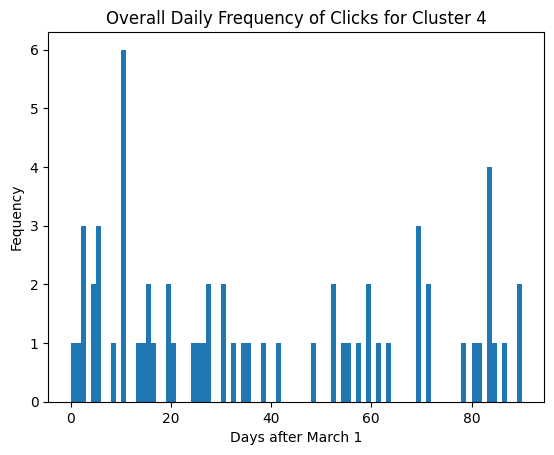

Cluster 5 -- Descriptive statistics and histogram
count    40.000000
mean     53.600000
std      32.550395
min       1.000000
25%      28.000000
50%      61.000000
75%      85.000000
max      85.000000
Name: DAYSAFTERDBSTART, dtype: float64


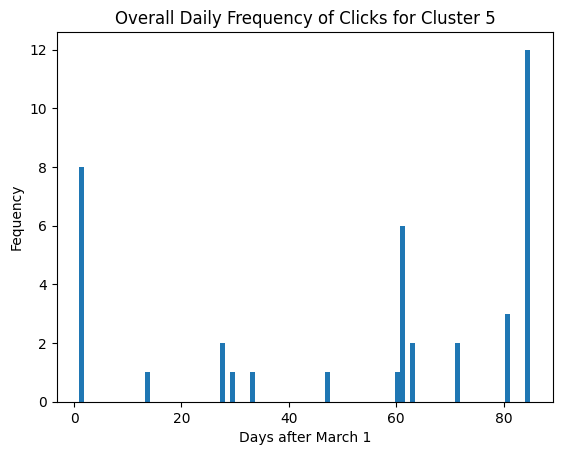

Cluster 6 -- Descriptive statistics and histogram
count    420.000000
mean      42.783333
std       24.995622
min        0.000000
25%       23.000000
50%       41.500000
75%       61.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


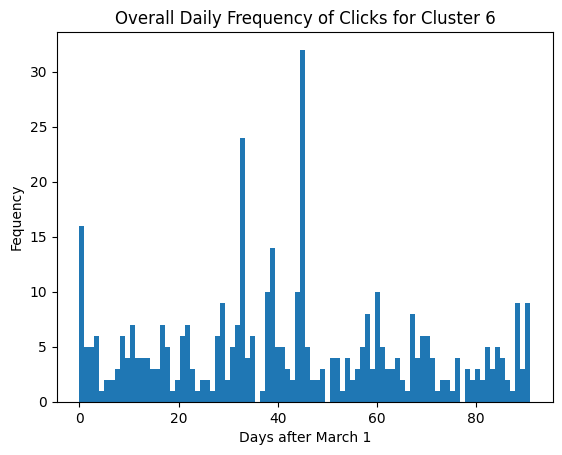

Cluster 7 -- Descriptive statistics and histogram
count    157.000000
mean      46.401274
std       29.623895
min        0.000000
25%       19.000000
50%       47.000000
75%       72.000000
max       90.000000
Name: DAYSAFTERDBSTART, dtype: float64


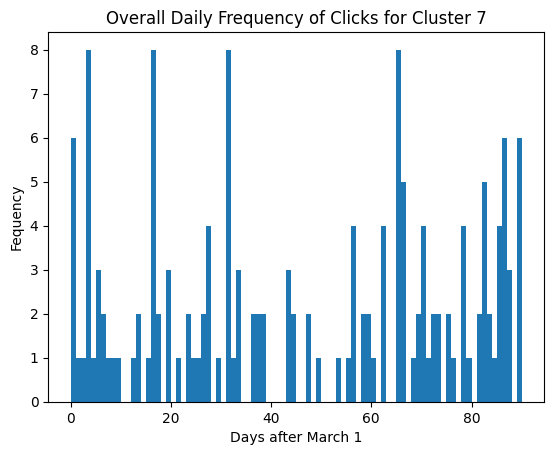

Cluster 8 -- Descriptive statistics and histogram
count    148.000000
mean      45.824324
std       27.293745
min        3.000000
25%       17.750000
50%       46.000000
75%       69.000000
max       90.000000
Name: DAYSAFTERDBSTART, dtype: float64


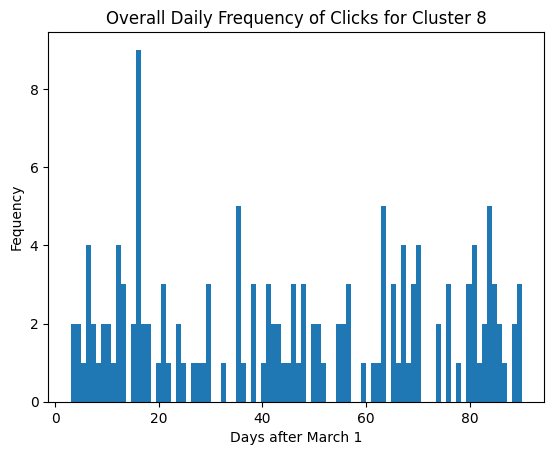

Cluster 9 -- Descriptive statistics and histogram
count    160.0000
mean      46.1000
std       26.1354
min        2.0000
25%       24.0000
50%       45.5000
75%       67.0000
max       91.0000
Name: DAYSAFTERDBSTART, dtype: float64


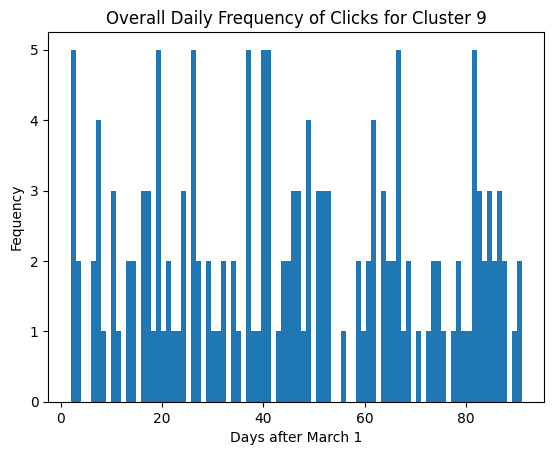

Cluster 10 -- Descriptive statistics and histogram
count    229.000000
mean      48.663755
std       27.177544
min        0.000000
25%       26.000000
50%       50.000000
75%       73.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


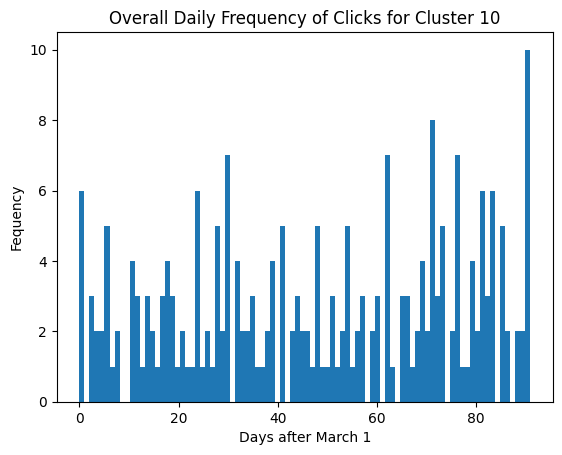

Cluster 11 -- Descriptive statistics and histogram
count    87.000000
mean     56.793103
std       1.356620
min      48.000000
25%      57.000000
50%      57.000000
75%      57.000000
max      57.000000
Name: DAYSAFTERDBSTART, dtype: float64


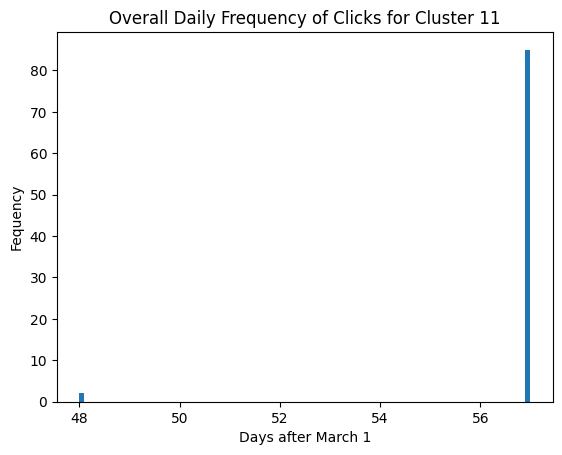

Cluster 12 -- Descriptive statistics and histogram
count    144.000000
mean      49.131944
std       30.401336
min        0.000000
25%       25.000000
50%       48.000000
75%       79.000000
max       91.000000
Name: DAYSAFTERDBSTART, dtype: float64


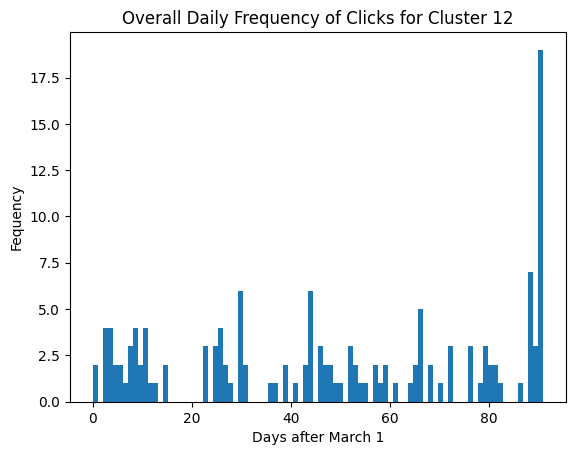

In [17]:
# At day scale

for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['DAYSAFTERDBSTART'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['DAYSAFTERDBSTART'], bins=90)  # Each bin represents a day
    plt.xlabel("Days after March 1")
    plt.ylabel("Fequency")
    plt.title(f"Overall Daily Frequency of Clicks for Cluster {i}")
    plt.show()

Cluster 0 -- Descriptive statistics and histogram
count      84.000000
mean      701.761905
std       394.616746
min         5.000000
25%       427.000000
50%       601.500000
75%      1065.000000
max      1375.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


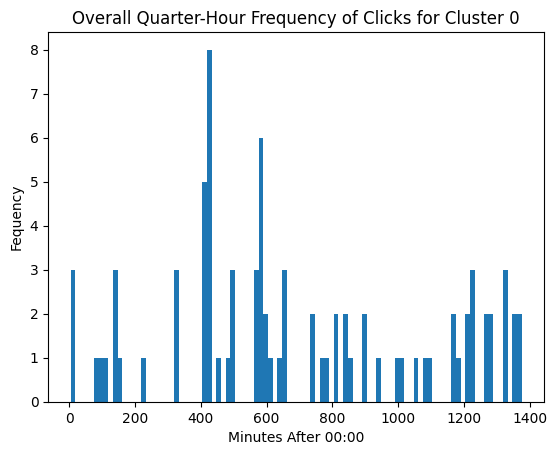

Cluster 1 -- Descriptive statistics and histogram
count     169.000000
mean      664.307692
std       347.164895
min        10.000000
25%       483.000000
50%       558.000000
75%       879.000000
max      1396.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


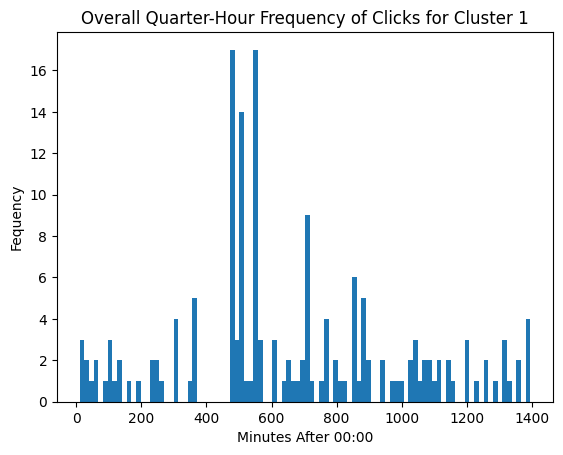

Cluster 2 -- Descriptive statistics and histogram
count     147.000000
mean      965.755102
std       395.506414
min        13.000000
25%       689.500000
50%      1042.000000
75%      1338.000000
max      1439.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


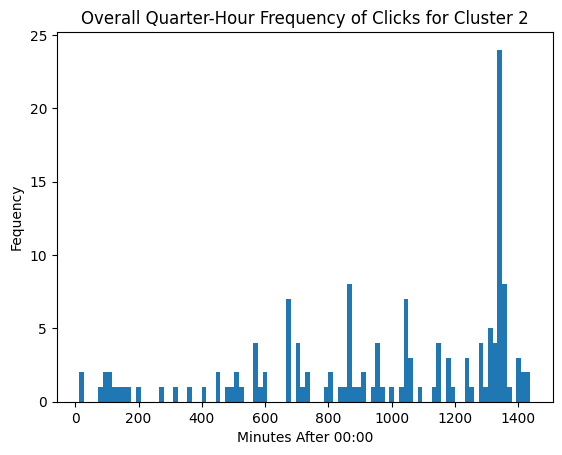

Cluster 3 -- Descriptive statistics and histogram
count     180.000000
mean      766.222222
std       394.659992
min         7.000000
25%       450.750000
50%       813.500000
75%      1128.500000
max      1432.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


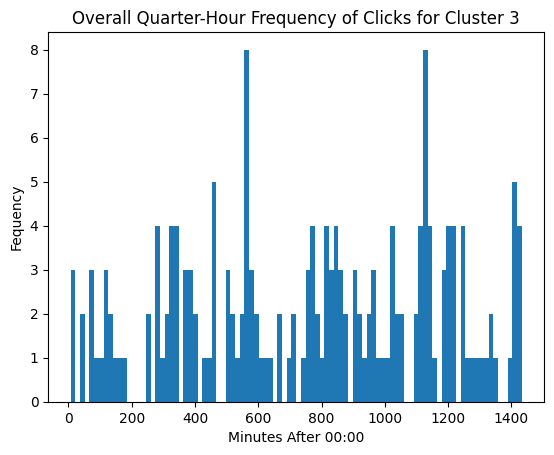

Cluster 4 -- Descriptive statistics and histogram
count      63.000000
mean      798.984127
std       424.195842
min         4.000000
25%       397.500000
50%       742.000000
75%      1205.500000
max      1438.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


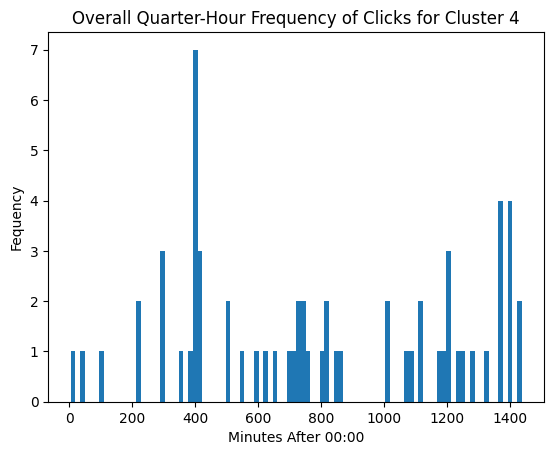

Cluster 5 -- Descriptive statistics and histogram
count      40.000000
mean     1026.425000
std       403.065235
min       147.000000
25%       706.750000
50%      1226.000000
75%      1423.000000
max      1423.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


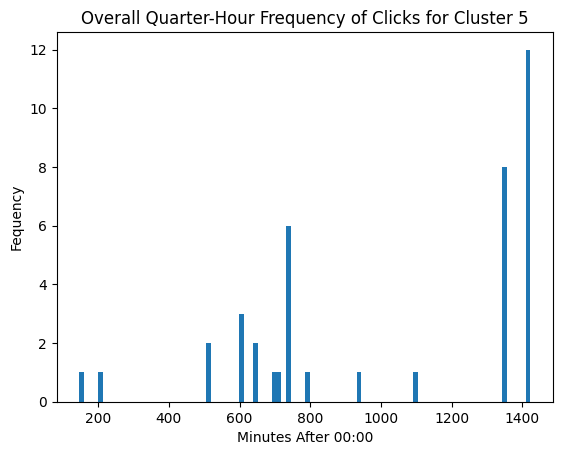

Cluster 6 -- Descriptive statistics and histogram
count     420.000000
mean      779.719048
std       386.449553
min         1.000000
25%       524.250000
50%       784.000000
75%      1088.000000
max      1438.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


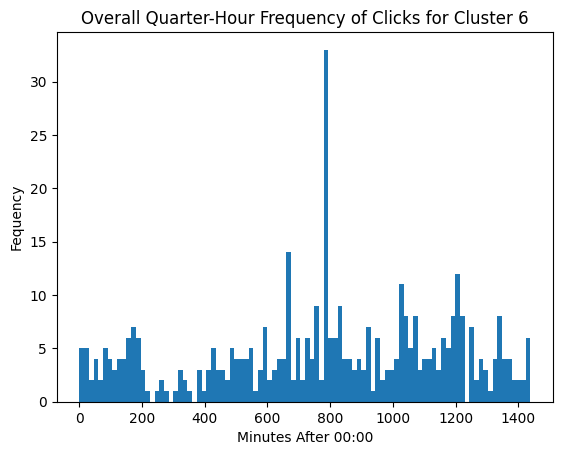

Cluster 7 -- Descriptive statistics and histogram
count     157.000000
mean      781.089172
std       440.758675
min        38.000000
25%       389.000000
50%       866.000000
75%      1161.000000
max      1422.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


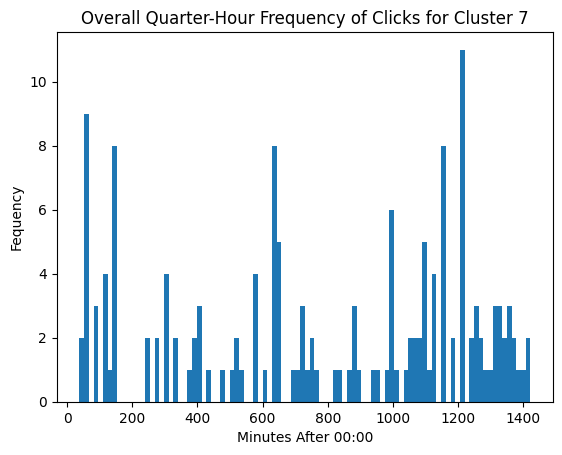

Cluster 8 -- Descriptive statistics and histogram
count     148.000000
mean      773.871622
std       402.406558
min        10.000000
25%       537.250000
50%       768.500000
75%      1139.750000
max      1437.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


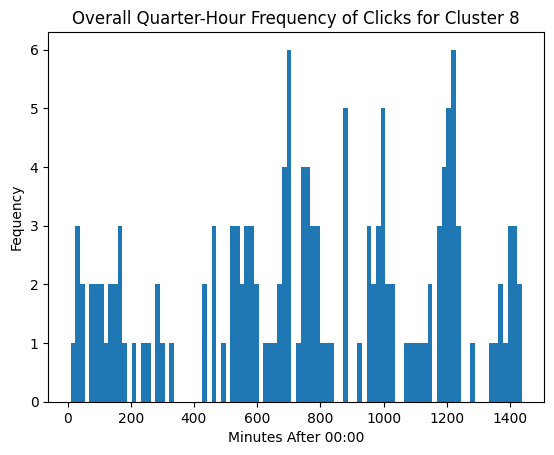

Cluster 9 -- Descriptive statistics and histogram
count     160.000000
mean      714.912500
std       434.801428
min        11.000000
25%       357.000000
50%       711.000000
75%      1075.250000
max      1423.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


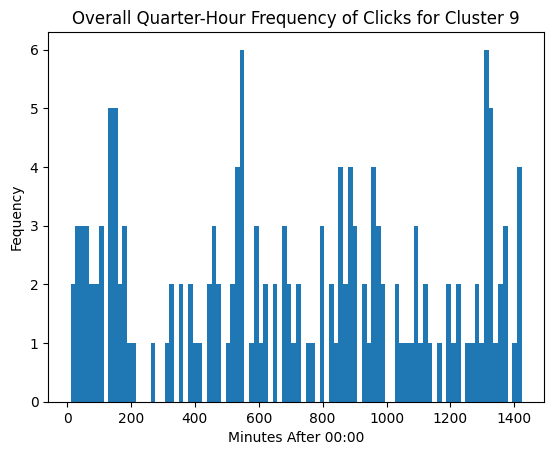

Cluster 10 -- Descriptive statistics and histogram
count     229.000000
mean      771.899563
std       412.429264
min         5.000000
25%       499.000000
50%       769.000000
75%      1104.000000
max      1436.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


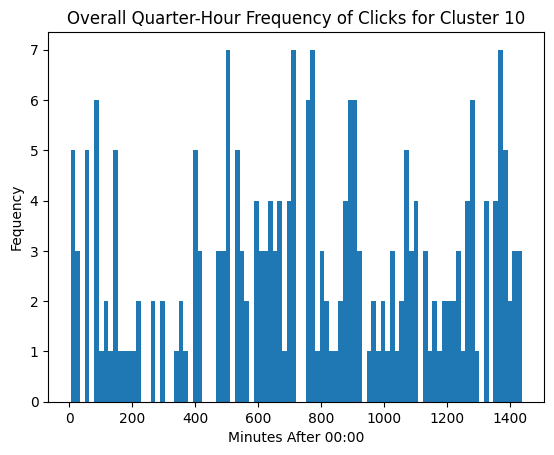

Cluster 11 -- Descriptive statistics and histogram
count     87.000000
mean     386.574713
std       82.452330
min      374.000000
25%      374.000000
50%      374.000000
75%      374.000000
max      921.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


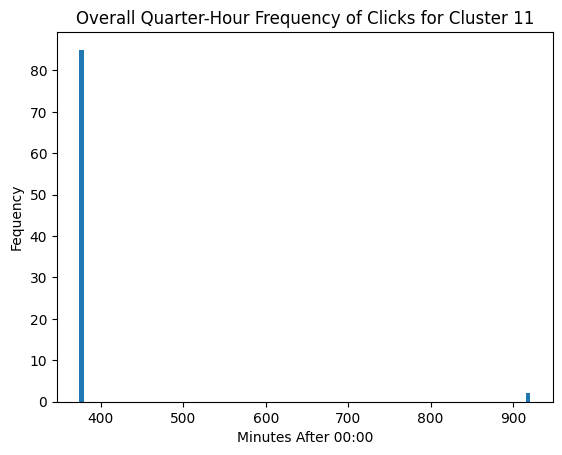

Cluster 12 -- Descriptive statistics and histogram
count     144.000000
mean      774.041667
std       425.759755
min         7.000000
25%       544.000000
50%       745.000000
75%      1156.750000
max      1434.000000
Name: MINUTESAFTERMIDNIGHT, dtype: float64


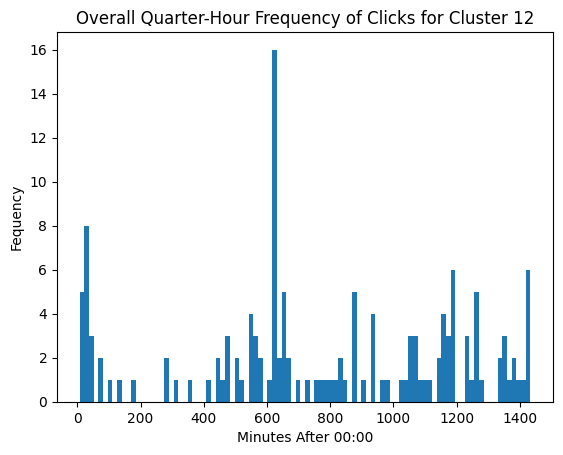

In [18]:
# At minute scale

for i in range(number_of_clusters):
    print(f"Cluster {i} -- Descriptive statistics and histogram")
    print(df[df['ClusterLabels'] == i]['MINUTESAFTERMIDNIGHT'].describe())
    plt.hist(df[df['ClusterLabels'] == i]['MINUTESAFTERMIDNIGHT'], bins=96)  # Each bin represents a day
    plt.xlabel("Minutes After 00:00")
    plt.ylabel("Fequency")
    plt.title(f"Overall Quarter-Hour Frequency of Clicks for Cluster {i}")
    plt.show()
    
